In [1]:
import os
import pickle 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import model_selection
from sklearn import metrics
from sklearn import multioutput

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

Loading the data

In [3]:
cwd = os.getcwd()
x = pd.read_csv(os.path.join(cwd, '../INSTANCES/chosen_data/data_x.csv'))
y = pd.read_csv(os.path.join(cwd, '../INSTANCES/chosen_data/data_y.csv'))

In [4]:
x = x.drop(columns=['instance_id'])
y = y.drop(columns=['instance_id'])

In [5]:
def log10_transform_data(data):
    minimum_log10_value = 0.001
    data[data < minimum_log10_value] = minimum_log10_value
    return np.log10(data)

In [6]:
y = log10_transform_data(y)

In [7]:
number_of_solvers = y.shape[1]
number_of_solvers

31

In [8]:
solver_names = y.columns

Splitting the data for training and testing

In [9]:
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 7)
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train_val, y_train_val, test_size = 0.3, random_state = 7)

Scaling the data

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

scaler = preprocessing.StandardScaler()
scaler.fit(x_train_val)
x_train_val = scaler.transform(x_train_val)
x_test = scaler.transform(x_test)

Finding the best configuration using validation set

In [11]:
n_neighbors = np.arange(1, 11)
weights = ['uniform', 'distance']
algorithm = ['ball_tree', 'kd_tree', 'brute'] 

In [12]:
r2_scores = np.empty((len(n_neighbors), len(weights), len(algorithm), number_of_solvers))
rmse_scores = np.empty((len(n_neighbors), len(weights), len(algorithm), number_of_solvers))

In [13]:
progress_max = len(n_neighbors) * len(weights) * len(algorithm) * number_of_solvers
progress_bar = IntProgress(min=0, max=progress_max)

In [14]:
display(progress_bar)

for i in range(len(n_neighbors)):
    param_n_neighbors = n_neighbors[i]
    for j in range(len(weights)):
        param_weights = weights[j]
        for k in range(len(algorithm)):
            param_algorithm = algorithm[k]
            for l in range(number_of_solvers):
                model = neighbors.KNeighborsRegressor(
                    n_neighbors=param_n_neighbors, weights=param_weights, algorithm=param_algorithm, n_jobs=-1)
                model.fit(x_train, y_train.iloc[:, l:l+1])
                y_true, y_pred = y_val.iloc[:, l:l+1], model.predict(x_val)
                r2_score = metrics.r2_score(y_true, y_pred)
                r2_scores[i, j, k, l] = r2_score
                rmse_score = metrics.mean_squared_error(y_true, y_pred, squared=False)
                rmse_scores[i, j, k, l] = rmse_score
                progress_bar.value += 1

IntProgress(value=0, max=1860)

In [15]:
with open('KNN_model_search_results.csv', 'w', encoding='utf-8') as csv:
    csv.write('n_neighbors,weights,algorithm,solver name,r2 score,rmse score\n')
    for i in range(len(n_neighbors)):
        param_n_neighbors = n_neighbors[i]
        for j in range(len(weights)):
            param_weights = weights[j]
            for k in range(len(algorithm)):
                param_algorithm = algorithm[k]
                for l in range(number_of_solvers):
                    solver_name = solver_names[l]
                    row = f'{param_n_neighbors},{param_weights},{param_algorithm},{solver_name},{r2_scores[i, j, k, l]},{rmse_scores[i, j, k, l]}\n'
                    csv.write(row)

In [16]:
with open('KNN_model_search_group_results.csv', 'w', encoding='utf-8') as csv:
    csv.write('n_neighbors,weights,algorithm,avg r2 score,min r2 score,max r2 score,avg rmse score,min rmse score,max rmse score\n')
    for i in range(len(n_neighbors)):
        param_n_neighbors = n_neighbors[i]
        for j in range(len(weights)):
            param_weights = weights[j]
            for k in range(len(algorithm)):
                param_algorithm = algorithm[k]
                avg_r2_score = np.average(r2_scores[i, j, k])
                min_r2_score = np.min(r2_scores[i, j, k])
                max_r2_score = np.max(r2_scores[i, j, k])
                avg_rmse_score = np.average(rmse_scores[i, j, k])
                min_rmse_score = np.min(rmse_scores[i, j, k])
                max_rmse_score = np.max(rmse_scores[i, j, k])
                row = f'{param_n_neighbors},{param_weights},{param_algorithm},{avg_r2_score},{min_r2_score},{max_r2_score},{avg_rmse_score},{min_rmse_score},{max_rmse_score}\n'
                csv.write(row)

Evaluate the best model

In [17]:
train_data = pd.read_csv('KNN_model_search_group_results.csv')
avg_r2_score = train_data['avg r2 score']
idx = np.argmax(avg_r2_score)
best_data = train_data.iloc[idx]
best_data

n_neighbors              4
weights           distance
algorithm            brute
avg r2 score      0.704299
min r2 score      0.623408
max r2 score      0.838219
avg rmse score    0.798195
min rmse score    0.511384
max rmse score    0.946319
Name: 23, dtype: object

In [18]:
best_params = { 
    'n_neighbors': best_data['n_neighbors'], 
    'weights': best_data['weights'],
    'algorithm': best_data['algorithm']
}

In [19]:
best_model = multioutput.MultiOutputRegressor(neighbors.KNeighborsRegressor(**best_params, n_jobs=-1))
best_model.fit(x_train_val, y_train_val)

MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='brute',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=-1, n_neighbors=4,
                                                   p=2, weights='distance'),
                     n_jobs=None)

In [20]:
y_true, y_pred = y_test, best_model.predict(x_test)
r2_scores_test = np.empty((number_of_solvers, ))
rmse_scores_test = np.empty((number_of_solvers, ))
for i in range(number_of_solvers):
    r2_scores_test[i] = metrics.r2_score(y_true.iloc[:, i:i+1], y_pred[:, i:i+1])
    rmse_scores_test[i] = metrics.mean_squared_error(y_true.iloc[:, i:i+1], y_pred[:, i:i+1], squared=False)

In [21]:
r2_score_test_avg = np.average(r2_scores_test)
rmse_score_test_avg = np.average(rmse_scores_test)
print(f'Average R2 score: {r2_score_test_avg}, Average RMSE score: {rmse_score_test_avg}')

Average R2 score: 0.6423463523933575, Average RMSE score: 0.9414458347460204


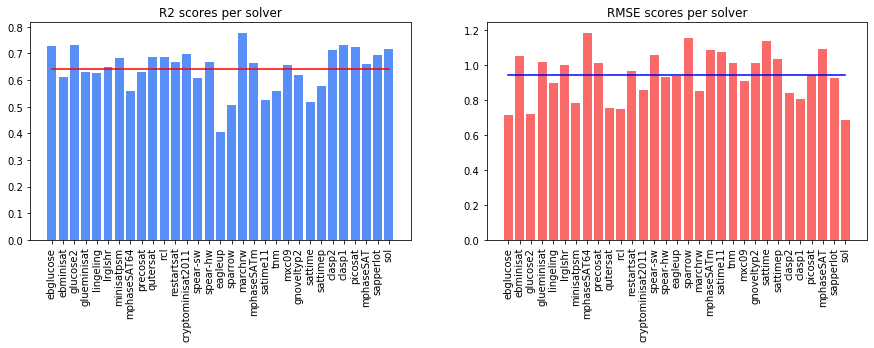

In [23]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
xticks = range(1, len(r2_scores_test)+1)
plt.title('R2 scores per solver')
plt.xticks(ticks=xticks, labels=list(solver_names), rotation=90)
plt.bar(xticks, r2_scores_test, color='#578FF7')
plt.plot([xticks[0], xticks[-1]], [r2_score_test_avg, r2_score_test_avg], 'r-')

plt.subplot(1, 2, 2)
xticks = range(1, len(rmse_scores_test)+1)
plt.title('RMSE scores per solver')
plt.xticks(ticks=xticks, labels=list(solver_names), rotation=90)
plt.bar(xticks, rmse_scores_test, color='#FA6A68')
plt.plot([xticks[0], xticks[-1]], [rmse_score_test_avg, rmse_score_test_avg], 'b-')

Saving the best KNN model to a file

In [24]:
with open('best_knn_model', 'wb') as model_file:
    pickle.dump(best_model, model_file)